spaCy model loaded successfully!
Loading cleaned data...
Loaded 14640 tweets
Using sample of 1000 tweets for faster processing

Performing Aspect-Based Sentiment Analysis...

Extracted 3938 aspect-sentiment pairs
Saved: data/absa_results.csv

Aspect Sentiment Distribution:
sentiment_label                               Negative  Neutral  Positive
aspect                                                                   
0 21mbps amp                                       0.0      1.0       0.0
0 clue                                             0.0      0.0       1.0
0600                                               0.0      1.0       0.0
0671 strand                                        0.0      1.0       0.0
1 5 million miles revenue first class ticket       0.0      1.0       0.0
...                                                ...      ...       ...
yr airline amp yr website                          0.0      0.0       1.0
yr site                                            0.0      

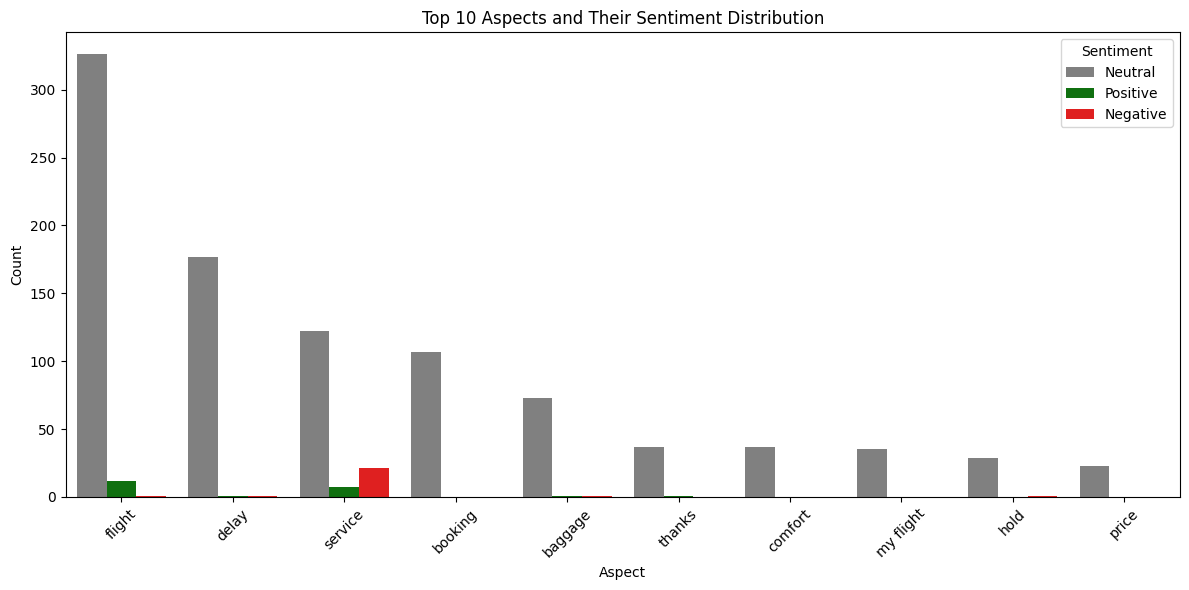

<Figure size 1000x800 with 0 Axes>

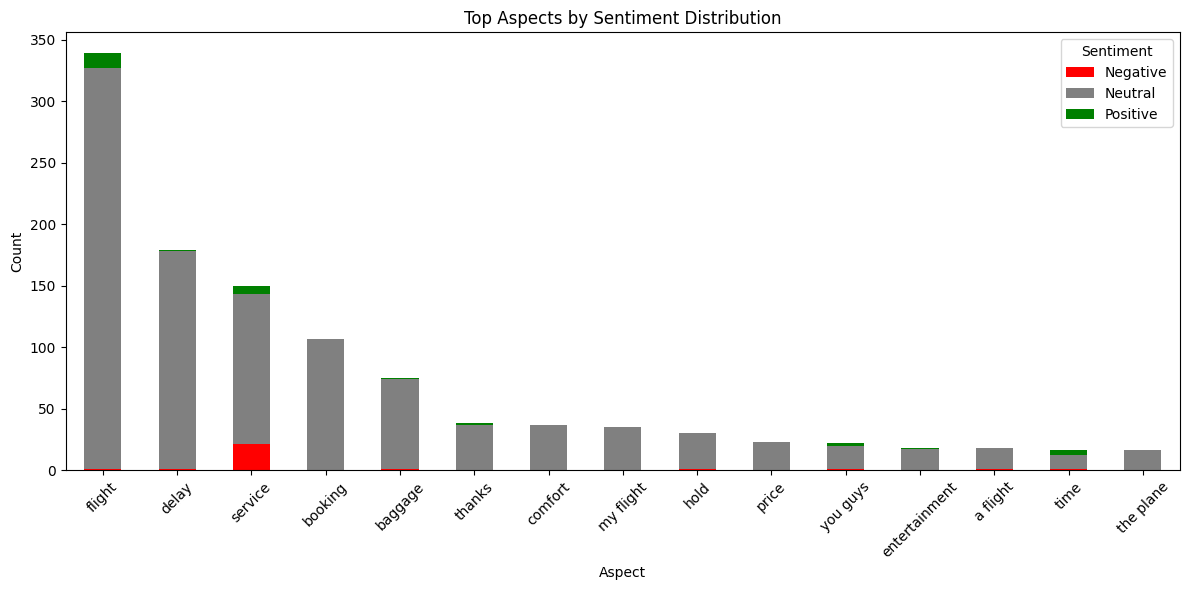


Aspect correlation with overall sentiment:


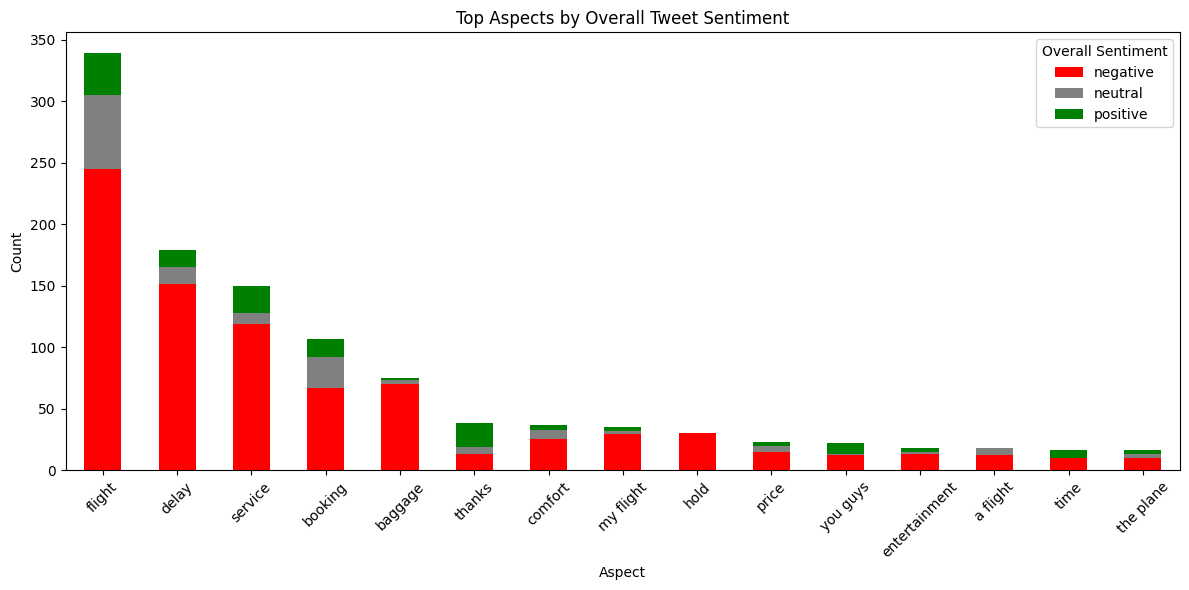


Example Aspect-Sentiment Visualization:
Text: @AmericanAir @ActingOutMgmnt Just make sure they remember to load the bags onto the plane. They Cancelled Flight the flight when they forget...

Identified Aspects:
- flight: Neutral
- the plane: Neutral
- the flight: Neutral
- @americanair @actingoutmgmnt: Neutral
- baggage: Neutral
- the bags: Neutral
- delay: Neutral



Saved: absa_utils.py

ABSA IMPLEMENTATION COMPLETE!

Next Steps:
1. Review the generated ABSA results in data/absa_results.csv
2. Examine the visualizations to understand aspect-sentiment relationships
3. Integrate these findings into your Streamlit dashboard
4. Consider enhancing with more sophisticated aspect detection or sentiment models


In [1]:
# Aspect-Based Sentiment Analysis (ABSA)
# Person B - Social Media Computing Assignment

# Import libraries
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import pickle
import warnings
warnings.filterwarnings('ignore')

# Load spaCy model
try:
    nlp = spacy.load('en_core_web_lg')  # Load medium/large model for better performance
except:
    print("Downloading spaCy model...")
    import subprocess
    subprocess.run(["python", "-m", "spacy", "download", "en_core_web_lg"])
    nlp = spacy.load('en_core_web_lg')

print("spaCy model loaded successfully!")

# Load cleaned data
print("Loading cleaned data...")
df = pd.read_csv('data/cleaned_data.csv')
print(f"Loaded {len(df)} tweets")

# Sample subset for faster processing during development
SAMPLE_SIZE = 1000  # Set to None to use full dataset
if SAMPLE_SIZE and len(df) > SAMPLE_SIZE:
    df = df.sample(SAMPLE_SIZE, random_state=42).reset_index(drop=True)
    print(f"Using sample of {SAMPLE_SIZE} tweets for faster processing")

# Define airline-specific aspects based on domain knowledge
AIRLINE_ASPECTS = {
    'service': ['service', 'staff', 'crew', 'employee', 'attendant', 'agent'],
    'flight': ['flight', 'trip', 'journey', 'travel'],
    'delay': ['delay', 'late', 'cancellation', 'cancel', 'on time', 'early'],
    'baggage': ['baggage', 'luggage', 'bag', 'suitcase'],
    'food': ['food', 'meal', 'snack', 'beverage', 'drink'],
    'comfort': ['seat', 'comfort', 'legroom', 'space', 'recline'],
    'entertainment': ['entertainment', 'movie', 'tv', 'screen', 'music'],
    'price': ['price', 'cost', 'fare', 'expensive', 'cheap'],
    'booking': ['booking', 'reservation', 'checkin', 'check-in', 'website', 'app'],
    'safety': ['safety', 'clean', 'hygiene', 'mask', 'covid']
}

# Function to extract aspects using rule-based matching
def extract_aspects(text, nlp_model=nlp):
    """Extract aspects from text using noun phrases and predefined aspects"""
    doc = nlp_model(text)
    
    aspects = set()
    
    # Extract noun phrases
    for chunk in doc.noun_chunks:
        # Filter out pronouns and very short phrases
        if chunk.root.pos_ in ['NOUN', 'PROPN'] and len(chunk.text) > 2:
            # Use lemma form for normalization
            aspects.add(chunk.text.lower())
    
    # Extract predefined aspects
    for aspect, keywords in AIRLINE_ASPECTS.items():
        for keyword in keywords:
            if keyword in text.lower():
                aspects.add(aspect)
    
    return list(aspects)

# Function to analyze sentiment for each aspect
def analyze_aspect_sentiment(text, aspect, sentiment_model=None):
    """
    Analyze sentiment for a specific aspect in text
    Uses simple heuristic if no model provided
    """
    if sentiment_model is None:
        # Simple heuristic-based sentiment analysis
        positive_words = ['good', 'great', 'excellent', 'awesome', 'fantastic', 
                         'wonderful', 'amazing', 'love', 'like', 'happy']
        negative_words = ['bad', 'poor', 'terrible', 'horrible', 'awful',
                         'disappointing', 'hate', 'worst', 'unhappy']
        
        # Check if aspect is in a positive or negative context
        aspect_pos = text.lower().find(aspect.lower())
        if aspect_pos == -1:
            return 1  # Neutral if aspect not found in text
        
        # Look at surrounding words
        window = text[max(0, aspect_pos-30):min(len(text), aspect_pos+30)]
        pos_count = sum(1 for word in positive_words if word in window.lower())
        neg_count = sum(1 for word in negative_words if word in window.lower())
        
        if pos_count > neg_count:
            return 2  # Positive
        elif neg_count > pos_count:
            return 0  # Negative
        else:
            return 1  # Neutral
    else:
        # Use provided sentiment model (LSTM/BERT)
        # This would be implemented based on your specific model
        pass

# Perform ABSA on the dataset
print("\nPerforming Aspect-Based Sentiment Analysis...")
absa_results = []

for idx, row in df.iterrows():
    text = row['cleaned_text']
    aspects = extract_aspects(text)
    
    for aspect in aspects:
        sentiment = analyze_aspect_sentiment(text, aspect)
        absa_results.append({
            'tweet_id': row['tweet_id'],
            'text': row['original_text'],
            'cleaned_text': text,
            'aspect': aspect,
            'sentiment': sentiment,
            'sentiment_label': ['Negative', 'Neutral', 'Positive'][sentiment],
            'overall_sentiment': row['airline_sentiment']
        })

# Create ABSA DataFrame
absa_df = pd.DataFrame(absa_results)
print(f"\nExtracted {len(absa_df)} aspect-sentiment pairs")

# Save ABSA results
absa_df.to_csv('data/absa_results.csv', index=False)
print("Saved: data/absa_results.csv")

# Aspect Sentiment Analysis
print("\nAspect Sentiment Distribution:")
aspect_sentiment_counts = absa_df.groupby(['aspect', 'sentiment_label']).size().unstack().fillna(0)
print(aspect_sentiment_counts)

# Visualize top aspects and their sentiments
top_aspects = absa_df['aspect'].value_counts().nlargest(10).index.tolist()
top_aspects_df = absa_df[absa_df['aspect'].isin(top_aspects)]

plt.figure(figsize=(12, 6))
sns.countplot(data=top_aspects_df, x='aspect', hue='sentiment_label', 
              order=top_aspects, palette={'Negative': 'red', 'Neutral': 'gray', 'Positive': 'green'})
plt.title('Top 10 Aspects and Their Sentiment Distribution')
plt.xlabel('Aspect')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

# Aspect-Sentiment Co-occurrence
plt.figure(figsize=(10, 8))
aspect_sentiment_counts['total'] = aspect_sentiment_counts.sum(axis=1)
aspect_sentiment_counts = aspect_sentiment_counts.sort_values('total', ascending=False).head(15)
aspect_sentiment_counts = aspect_sentiment_counts.drop(columns=['total'])

aspect_sentiment_counts.plot(kind='bar', stacked=True, 
                            color=['red', 'gray', 'green'], 
                            figsize=(12, 6))
plt.title('Top Aspects by Sentiment Distribution')
plt.xlabel('Aspect')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

# Aspect correlation with overall sentiment
print("\nAspect correlation with overall sentiment:")
aspect_overall_sentiment = absa_df.groupby(['aspect', 'overall_sentiment']).size().unstack().fillna(0)
aspect_overall_sentiment['total'] = aspect_overall_sentiment.sum(axis=1)
aspect_overall_sentiment = aspect_overall_sentiment.sort_values('total', ascending=False).head(15)
aspect_overall_sentiment = aspect_overall_sentiment.drop(columns=['total'])

aspect_overall_sentiment.plot(kind='bar', stacked=True, 
                             color=['red', 'gray', 'green'], 
                             figsize=(12, 6))
plt.title('Top Aspects by Overall Tweet Sentiment')
plt.xlabel('Aspect')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Overall Sentiment')
plt.tight_layout()
plt.show()

# Example aspect-based sentiment visualization
def visualize_aspect_sentiment(text):
    """Fixed version with proper span handling"""
    doc = nlp(text)
    aspects = extract_aspects(text)
    
    print(f"Text: {text}")
    print("\nIdentified Aspects:")
    for aspect in aspects:
        sentiment = analyze_aspect_sentiment(text, aspect)
        print(f"- {aspect}: {['Negative', 'Neutral', 'Positive'][sentiment]}")
    
    # Create spans only for valid aspect positions
    spans = []
    for aspect in aspects:
        start = text.lower().find(aspect.lower())
        if start != -1:
            end = start + len(aspect)
            span = doc.char_span(start, end, label="ASPECT")
            if span is not None:
                spans.append(span)
    
    doc.ents = spans
    if doc.ents:
        colors = {"ASPECT": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
        options = {"ents": ["ASPECT"], "colors": colors}
        displacy.render(doc, style="ent", options=options, jupyter=True)

# Example visualization
print("\nExample Aspect-Sentiment Visualization:")
try:
    sample_text = df.sample(1)['original_text'].values[0]
    visualize_aspect_sentiment(sample_text)
except Exception as e:
    print(f"Error in visualization: {e}")
    print("Sample text that caused error:", sample_text)

# Save ABSA visualization function for dashboard
with open('absa_utils.py', 'w') as f:
    f.write('''# ABSA utilities for dashboard

import spacy
from spacy import displacy
from collections import defaultdict

nlp = spacy.load('en_core_web_lg')

AIRLINE_ASPECTS = {
    'service': ['service', 'staff', 'crew', 'employee', 'attendant', 'agent'],
    'flight': ['flight', 'trip', 'journey', 'travel'],
    'delay': ['delay', 'late', 'cancellation', 'cancel', 'on time', 'early'],
    'baggage': ['baggage', 'luggage', 'bag', 'suitcase'],
    'food': ['food', 'meal', 'snack', 'beverage', 'drink'],
    'comfort': ['seat', 'comfort', 'legroom', 'space', 'recline'],
    'entertainment': ['entertainment', 'movie', 'tv', 'screen', 'music'],
    'price': ['price', 'cost', 'fare', 'expensive', 'cheap'],
    'booking': ['booking', 'reservation', 'checkin', 'check-in', 'website', 'app'],
    'safety': ['safety', 'clean', 'hygiene', 'mask', 'covid']
}

def extract_aspects(text, nlp_model=nlp):
    """Extract aspects from text using noun phrases and predefined aspects"""
    doc = nlp_model(text)
    
    aspects = set()
    
    # Extract noun phrases
    for chunk in doc.noun_chunks:
        if chunk.root.pos_ in ['NOUN', 'PROPN'] and len(chunk.text) > 2:
            aspects.add(chunk.text.lower())
    
    # Extract predefined aspects
    for aspect, keywords in AIRLINE_ASPECTS.items():
        for keyword in keywords:
            if keyword in text.lower():
                aspects.add(aspect)
    
    return list(aspects)

def analyze_aspect_sentiment(text, aspect):
    """Simple sentiment analysis for aspects"""
    positive_words = ['good', 'great', 'excellent', 'awesome', 'fantastic', 
                     'wonderful', 'amazing', 'love', 'like', 'happy']
    negative_words = ['bad', 'poor', 'terrible', 'horrible', 'awful',
                     'disappointing', 'hate', 'worst', 'unhappy']
    
    aspect_pos = text.lower().find(aspect.lower())
    if aspect_pos == -1:
        return 1  # Neutral
    
    window = text[max(0, aspect_pos-30):min(len(text), aspect_pos+30)]
    pos_count = sum(1 for word in positive_words if word in window.lower())
    neg_count = sum(1 for word in negative_words if word in window.lower())
    
    if pos_count > neg_count:
        return 2  # Positive
    elif neg_count > pos_count:
        return 0  # Negative
    else:
        return 1  # Neutral

def visualize_aspect_sentiment(text):
    """Visualize aspect sentiment for a given text"""
    doc = nlp(text)
    aspects = extract_aspects(text)
    
    print(f"Text: {text}")
    print("\\nIdentified Aspects:")
    for aspect in aspects:
        sentiment = analyze_aspect_sentiment(text, aspect)
        print(f"- {aspect}: {['Negative', 'Neutral', 'Positive'][sentiment]}")
    
    colors = {"ASPECT": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
    options = {"ents": ["ASPECT"], "colors": colors}
    
    ents = []
    for aspect in aspects:
        start = text.lower().find(aspect.lower())
        if start != -1:
            end = start + len(aspect)
            ents.append({"start": start, "end": end, "label": "ASPECT"})
    
    doc.ents = [doc.char_span(e["start"], e["end"], label=e["label"]) for e in ents]
    displacy.render(doc, style="ent", options=options, jupyter=True)
''')

print("\nSaved: absa_utils.py")

print("\n" + "="*60)
print("ABSA IMPLEMENTATION COMPLETE!")
print("="*60)

print("\nNext Steps:")
print("1. Review the generated ABSA results in data/absa_results.csv")
print("2. Examine the visualizations to understand aspect-sentiment relationships")
print("3. Integrate these findings into your Streamlit dashboard")
print("4. Consider enhancing with more sophisticated aspect detection or sentiment models")